### Project #2 Atari game PONG

In [16]:
import gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import imageio
import matplotlib.pyplot as plt
import time

In [17]:
# hyperparameter
ENV_NAME = 'ALE/Pong-ram-v5'
state_size = 128            # 입력으로 받을 상태의 차원
action_size = 6             # 액션 수
batch_size = 64             # 배치사이즈
gamma = 0.99                # 할인율 (discount factor)
epsilon = 1.0               # epsilon 초기값
epsilon_min = 0.1           # epsilon 최소값
epsilon_decay = 0.995       # epsilon 감소율
learning_rate = 0.00025     # 학습률
num_episodes = 20000         # 에피소드 수
memory_size = 50000         # 리플레이 버퍼 크기
update_target_every = 5     # 타겟 네트워크 업데이트 주기

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [18]:
# DQN Agent class
class DQNAgent(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQNAgent, self).__init__()
        # Input layer
        self.fc1 = nn.Linear(state_size, 256)
        # Hidden layer
        self.fc2 = nn.Linear(256, 256)
        # Output layer
        self.fc3 = nn.Linear(256, action_size)

    def forward(self, x):
        # Normalize the input
        x = x / 255.0
        # Forward pass through the network
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [19]:
# Agent class
class Agent:
    def __init__(self, state_size, action_size):
        # Main network and target network
        self.model = DQNAgent(state_size, action_size).to(device)
        self.target_model = DQNAgent(state_size, action_size).to(device)
        # Optimizer
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        # Replay buffer
        self.memory = deque(maxlen=memory_size)
        # Exploration rate
        self.epsilon = epsilon

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        # Epsilon-greedy action selection
        if random.random() <= self.epsilon:
            # Explore: select a random action
            return random.randrange(action_size)
        # Exploit: select the action with max Q-value
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self):
        # Training the network using replay buffer
        if len(self.memory) < batch_size:
            return
        # Sample a minibatch from the replay buffer
        minibatch = random.sample(self.memory, batch_size)

        # Convert minibatch to tensors efficiently
        states = torch.from_numpy(np.vstack([m[0] for m in minibatch])).float().to(device)
        actions = torch.from_numpy(np.vstack([m[1] for m in minibatch])).long().to(device)
        rewards = torch.from_numpy(np.vstack([m[2] for m in minibatch])).float().to(device)
        next_states = torch.from_numpy(np.vstack([m[3] for m in minibatch])).float().to(device)
        dones = torch.from_numpy(np.vstack([float(m[4]) for m in minibatch])).float().to(device)

        # Calculate Q-values
        q_values = self.model(states).gather(1, actions)
        # Calculate target Q-values
        next_q_values = self.target_model(next_states).max(1)[0].unsqueeze(1)
        target_q_values = rewards + (gamma * next_q_values * (1 - dones))

        # Compute loss and update the network
        loss = F.mse_loss(q_values, target_q_values.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

In [20]:

env = gym.make(ENV_NAME, render_mode="rgb_array")
agent = Agent(state_size, action_size)

rewards_list = []
best_reward = -float('inf')
best_frames = []


In [21]:
start = time.time()
# Training loop
for e in range(num_episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False
    frames = []
    while not done:
        frame = env.render()
        frames.append(frame)

        action = agent.act(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        agent.replay()

    if e % update_target_every == 0:
        agent.update_target_model()

    # epsilon 감소
    if agent.epsilon > epsilon_min:
        agent.epsilon *= epsilon_decay

    # reward 기록
    rewards_list.append(total_reward)
    if total_reward > best_reward:
        best_reward = total_reward
        best_frames = frames

    if e % 100 == 0:
        torch.save(agent.model.state_dict(), f"Pong_DQN_model_{e}.pth")
        print(f"Episode: {e+1}/{num_episodes}, Score: {total_reward}, Epsilon: {agent.epsilon:.2f}")
    # Early stopping if desired performance is reached
    if total_reward >= 20:
        print("Desired performance achieved, stopping training.")
        break

end = time.time()
length = end - start

print("It took", length, "seconds!")

/home/ops/project/.venv/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(
/home/ops/project/.venv/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 1/20000, Score: -20.0, Epsilon: 0.99
Episode: 101/20000, Score: -19.0, Epsilon: 0.60
Episode: 201/20000, Score: -17.0, Epsilon: 0.37
Episode: 301/20000, Score: -17.0, Epsilon: 0.22
Episode: 401/20000, Score: -16.0, Epsilon: 0.13
Episode: 501/20000, Score: -18.0, Epsilon: 0.10
Episode: 601/20000, Score: -13.0, Epsilon: 0.10
Episode: 701/20000, Score: -15.0, Epsilon: 0.10
Episode: 801/20000, Score: -15.0, Epsilon: 0.10
Episode: 901/20000, Score: -11.0, Epsilon: 0.10
Episode: 1001/20000, Score: -12.0, Epsilon: 0.10
Episode: 1101/20000, Score: -13.0, Epsilon: 0.10
Episode: 1201/20000, Score: -9.0, Epsilon: 0.10
Episode: 1301/20000, Score: -14.0, Epsilon: 0.10
Episode: 1401/20000, Score: -10.0, Epsilon: 0.10
Episode: 1501/20000, Score: -8.0, Epsilon: 0.10
Episode: 1601/20000, Score: -13.0, Epsilon: 0.10
Episode: 1701/20000, Score: -11.0, Epsilon: 0.10
Episode: 1801/20000, Score: -11.0, Epsilon: 0.10
Episode: 1901/20000, Score: -10.0, Epsilon: 0.10
Episode: 2001/20000, Score: -16.0,

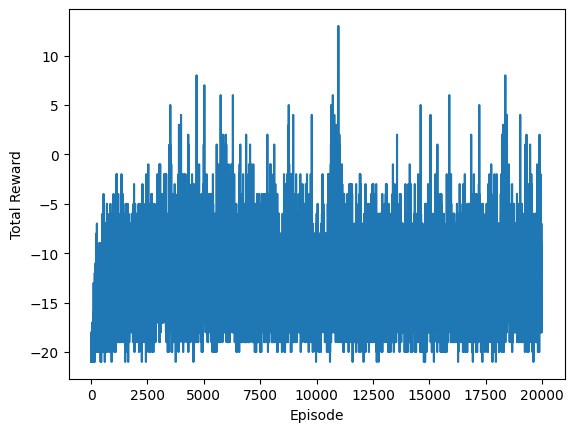

Best episode reward: 13.0


In [22]:
from common.utils import plot_total_reward
plot_total_reward(rewards_list)

env.close()
print(f"Best episode reward: {best_reward}")

In [24]:
torch.save(agent.model.state_dict(), f"Pong_DQN_model_20000.pth")

Best episode saved as best_Pong_game.gif


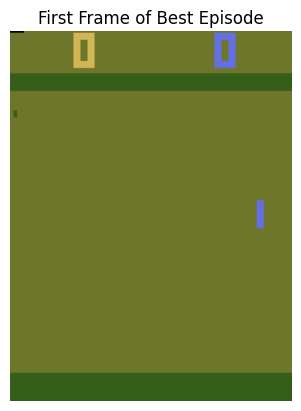

In [25]:
# 이미지로 저장
output_filename = "best_Pong_game.gif"
imageio.mimsave(output_filename, best_frames, fps=30)
print(f"Best episode saved as {output_filename}")

# 첫 장면만 시각화
plt.imshow(best_frames[0])
plt.title("First Frame of Best Episode")
plt.axis('off')
plt.show()